In [ ]:
!pip install scipy
!pip install matplotlib
!pip install pydmd
!pip install pykoopman
!pip install imageio
!pip install os
!pip install optht
!pip install derivative
!pip install lightning
!pip install imread
!pip install future
!pip install sphinx


import os
import matplotlib.pyplot as plt
import warnings
import scipy
import imageio
warnings.filterwarnings('ignore')

from pydmd import DMD
from matplotlib import animation
from IPython.display import HTML
import numpy as np
from os import listdir
import pykoopman as pk
import pandas as pd
from imread import imread

%matplotlib inline

import future
import sphinx

from sklearn.decomposition import PCA


from sklearn.preprocessing import StandardScaler
from pydmd import DMDc
from numpy.testing import assert_array_almost_equal

from numpy import linalg as LA
from pydmd import CDMD

from sklearn.datasets import fetch_openml
import sys
import cv2 as cv
import plotly.io as pio
import plotly.graph_objs as go
from PIL import Image
from skimage import color
from plotly import subplots
from sklearn.model_selection import train_test_split
pio.renderers.default = "colab"
from sklearn.decomposition import SparsePCA
import seaborn as sns

In [ ]:
import operator as op

In [ ]:
IMG_DIR = '/content/illum'
X = []
X_flat = []
count = 1
size1 = 352
size2 = 288
total = 89
print("Loading...")
for img in sorted(os.listdir(IMG_DIR)):
    if count == total + 1:
        break
    sys.stdout.write("\r" + str(count) + " / " + str(total))
    sys.stdout.flush()
    img_array = cv.imread(os.path.join(IMG_DIR, img), cv.IMREAD_GRAYSCALE,)
    img_pil = Image.fromarray(img_array)
    img_156x120 = np.array(img_pil.resize((size1, size2), Image.ANTIALIAS))
    X.append(img_156x120)
    img_array = img_156x120.flatten()
    X_flat.append(img_array)
    count += 1
print()
print("Done!")

Loading...
89 / 89
Done!


In [ ]:
X_flat = np.asarray(X_flat)
X_flat.shape

(89, 101376)

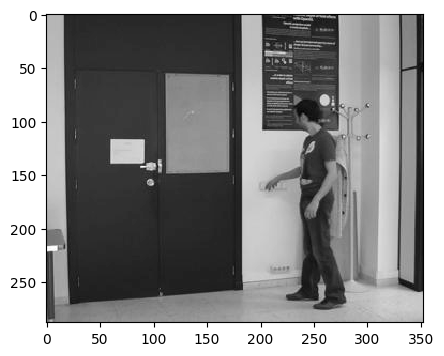

In [ ]:
images_dir = '/content/test'
plt.figure(figsize=(8,4));
plt.imshow(X_flat[30].reshape(288,352),
              cmap = plt.cm.gray, interpolation='nearest',
              clim=(0, 255));
plt.savefig(f"{images_dir}/label{[i]}.png")

In [ ]:
pca = PCA(n_components=total)
PC = pca.fit_transform(X_flat)
eigenvalues = pca.explained_variance_
explained_variance_ratio = pca.explained_variance_ratio_

time: 5.95 s (started: 2023-09-04 18:05:52 +00:00)


In [ ]:
PC.shape

(89, 89)

time: 11.3 ms (started: 2023-09-04 18:06:00 +00:00)


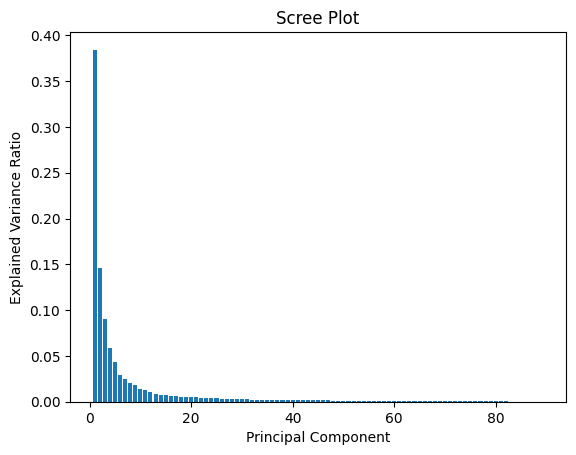

PC	Explained Variance Ratio	Cumulative Explained Variance Ratio
1.0	0.3842536129144319	0.3842536129144319
2.0	0.14649868517652698	0.5307522980909589
3.0	0.0902103866892926	0.6209626847802515
4.0	0.05823587708695366	0.6791985618672052
5.0	0.043126702586333235	0.7223252644535384
6.0	0.029069841528418155	0.7513951059819566
7.0	0.024773281757856893	0.7761683877398134
8.0	0.020460837729480465	0.7966292254692939
9.0	0.018425300827219136	0.8150545262965131
10.0	0.013901949951636856	0.8289564762481499
11.0	0.01240104039738905	0.841357516645539
12.0	0.010239662357570092	0.8515971790031092
13.0	0.0086770123238203	0.8602741913269295
14.0	0.0076352611403223605	0.8679094524672518
15.0	0.006888542181519732	0.8747979946487715
16.0	0.006510690796183392	0.8813086854449549
17.0	0.006026264512932766	0.8873349499578876
18.0	0.0056803807470782244	0.8930153307049659
19.0	0.005502813169200149	0.8985181438741661
20.0	0.005103281687701392	0.9036214255618674
21.0	0.004725319947348067	0.9083467455092155
22.0	0.0

In [ ]:
num_components = len(explained_variance_ratio)
plt.bar(range(1, num_components + 1), explained_variance_ratio)
plt.xlabel('Principal Component')
plt.ylabel('Explained Variance Ratio')
plt.title('Scree Plot')
plt.show()

# Summary table
cumulative_explained_variance_ratio = np.cumsum(explained_variance_ratio)
summary_table = np.column_stack((range(1, num_components + 1), explained_variance_ratio, cumulative_explained_variance_ratio))
print('PC\tExplained Variance Ratio\tCumulative Explained Variance Ratio')
for row in summary_table:
    print('\t'.join(str(x) for x in row))

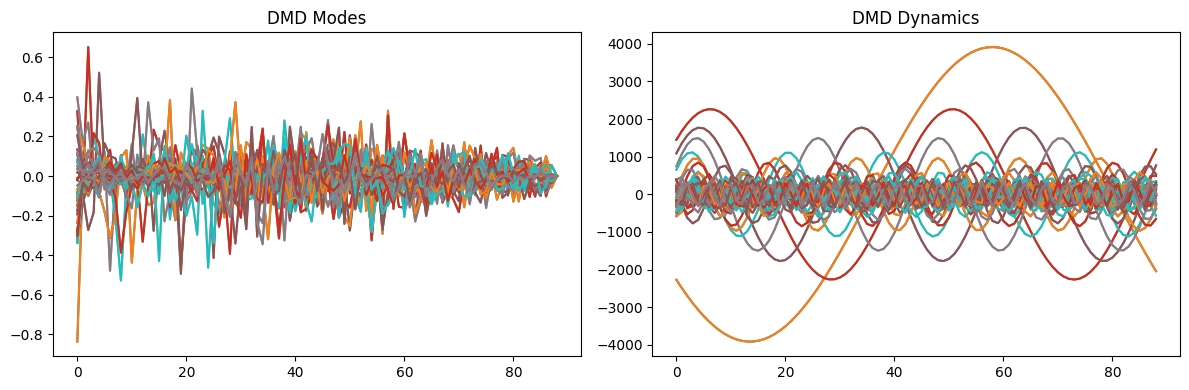

In [ ]:
Z = PC.T

# Perform DMD
dmd = DMD(svd_rank=89)
dmd.fit(Z)

# Access DMD modes and dynamics
modes = dmd.modes.T
dynamics = dmd.dynamics

# Visualize DMD modes and dynamics
plt.figure(figsize=(12, 4))

# Plot DMD modes
plt.subplot(1, 2, 1)
for mode in modes:
    plt.plot(mode)
plt.title('DMD Modes')

# Plot DMD dynamics
plt.subplot(1, 2, 2)
for dynamic in dynamics:
    plt.plot(dynamic)
plt.title('DMD Dynamics')

plt.tight_layout()
plt.show()


In [ ]:
snapshots_matrix = PC.T
random_matrix = np.random.permutation(
    snapshots_matrix.shape[0] * snapshots_matrix.shape[1]
)
random_matrix = random_matrix.reshape(
    snapshots_matrix.shape[1], snapshots_matrix.shape[0]
)

compression_matrix = random_matrix / np.linalg.norm(random_matrix)

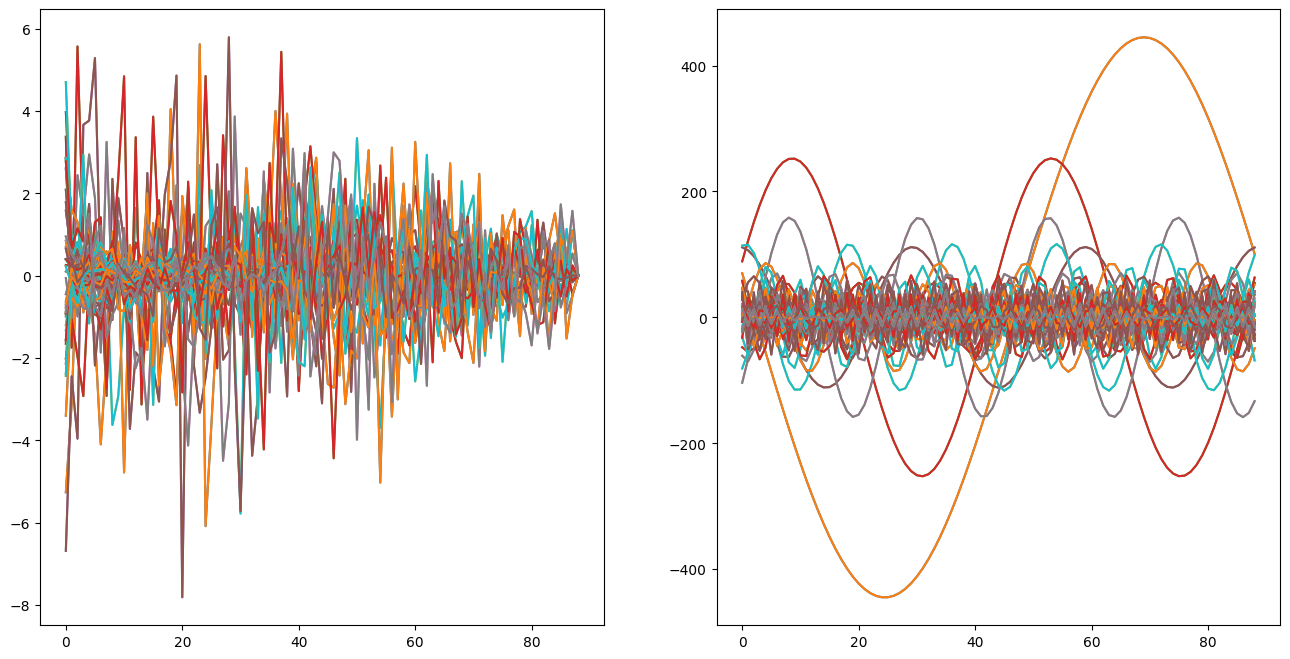

In [ ]:
cdmd = CDMD(svd_rank=89, compression_matrix=compression_matrix)
cdmd.fit(snapshots_matrix)

plt.figure(figsize=(16, 8))
plt.subplot(1, 2, 1)
plt.plot(cdmd.modes.real)
plt.subplot(1, 2, 2)
plt.plot(cdmd.dynamics.T.real)
plt.show()

In [ ]:
dmd_x = DMD(svd_rank=89)
dmd_x.fit(X_flat.T)

for dynamic in dmd_x.dynamics:
    plt.plot(dynamic)
plt.xlim(0, 60)
plt.ylim(-14000, 14000)
plt.title('DMD Dynamics')

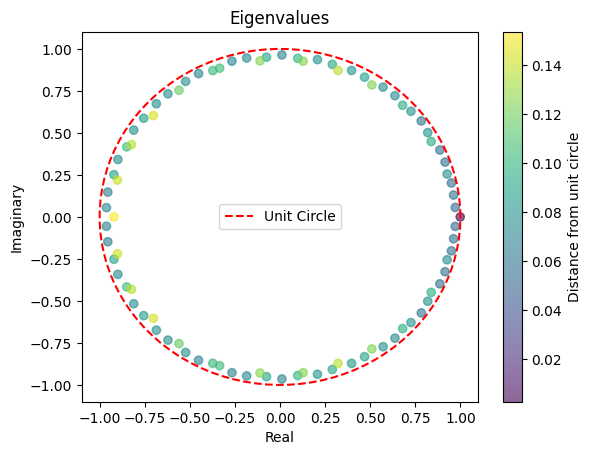

In [ ]:
eigenvalues = dmd_x.eigs

# Calculate distance from unit circle
distances = np.abs(eigenvalues.imag**2 + eigenvalues.real**2 - 1)

# Plot eigenvalues and unit circle
plt.figure()
plt.scatter(eigenvalues.real, eigenvalues.imag, c=distances, cmap='viridis', alpha=0.6)
plt.colorbar(label='Distance from unit circle')
plt.xlabel('Real')
plt.ylabel('Imaginary')
plt.title('Eigenvalues')

# Plot unit circle
theta = np.linspace(0, 2 * np.pi, 100)
plt.plot(np.cos(theta), np.sin(theta), color='red', linestyle='--', label='Unit Circle')
plt.legend()

plt.show()

In [ ]:
real = pd.DataFrame(eigenvalues.real)
imaginary = pd.DataFrame(eigenvalues.imag)
Combined = real + imaginary

In [ ]:
eigenvalues = pdmd.eigs
for eig in eigenvalues:
    if eig.imag > 0:  # Filter eigenvalues with positive imaginary parts
        print("Eigenvalue {}: distance from unit circle {}".format(eig, np.abs(np.sqrt(eig.imag**2 + eig.real**2) - 1)))

fig, ax = plt.subplots()
filtered_eigenvalues = [eig for eig in eigenvalues if abs(eig.real + eig.image) < 0.99]
colors = np.linspace(0, 1, len(filtered_eigenvalues))
edge_colors = plt.cm.rainbow(colors)
ax.scatter(np.real(filtered_eigenvalues), np.imag(filtered_eigenvalues), c=colors, cmap='rainbow', marker='o', edgecolors=edge_colors, facecolors='none')
unit_circle = plt.Circle((0, 0), 1, color='green', fill=False, linestyle='dashed')
ax.add_artist(unit_circle)
ax.set_aspect('equal', adjustable='box')
ax.set_xlim([-1.5, 1.5])
ax.set_ylim([-1.5, 1.5])
plt.xlabel('Real')
plt.ylabel('Imaginary')
#plt.title('Eigenvalues on the Unit Circle (Positive Imaginary Part)')
plt.grid(True)
plt.show()

In [ ]:
def explainedVariance(percentage, images):
    # percentage should be a decimal from 0 to 1
    pca = PCA(percentage)
    pca.fit(images)
    PC = pca.transform(images)
    snapshots_matrix = PC.T
    random_matrix = np.random.permutation(
      snapshots_matrix.shape[0] * snapshots_matrix.shape[1]
    )
    random_matrix = random_matrix.reshape(
      snapshots_matrix.shape[1], snapshots_matrix.shape[0]
    )

    compression_matrix = random_matrix / np.linalg.norm(random_matrix)

    cdmd = CDMD(svd_rank=89, compression_matrix=compression_matrix)
    cdmd.fit(snapshots_matrix)
    approxOriginal = pca.inverse_transform(cdmd.reconstructed_data.T)
    approxOriginal = approxOriginal.T.astype(np.float)
    return approxOriginal

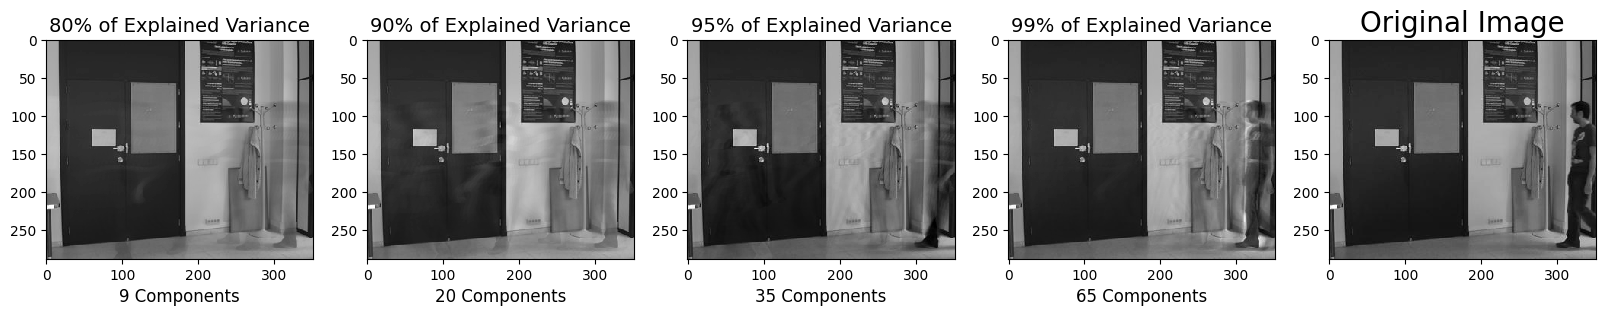

In [ ]:
plt.figure(figsize=(20,4));

plt.subplot(1, 5, 1);
plt.imshow(explainedVariance(.80, X_flat)[:,5].reshape(288,352),
              cmap = plt.cm.gray, interpolation='nearest',
              clim=(0, 255));
plt.xlabel('9 Components', fontsize = 12)
plt.title('80% of Explained Variance', fontsize = 14);

# 154 principal components
plt.subplot(1, 5, 2);
plt.imshow(explainedVariance(.9, X_flat)[:,5].reshape(288,352),
              cmap = plt.cm.gray, interpolation='nearest',
              clim=(0, 255));
plt.xlabel('20 Components', fontsize = 12)
plt.title('90% of Explained Variance', fontsize = 14);

plt.subplot(1, 5, 3);
plt.imshow(explainedVariance(.95, X_flat)[:,5].reshape(288,352),
              cmap = plt.cm.gray, interpolation='nearest',
              clim=(0, 255));
plt.xlabel('35 Components', fontsize = 12)
plt.title('95% of Explained Variance', fontsize = 14);

plt.subplot(1, 5, 4);
plt.imshow(explainedVariance(.99, X_flat)[:,5].reshape(288,352),
              cmap = plt.cm.gray, interpolation='nearest',
              clim=(0, 255));
plt.xlabel('65 Components', fontsize = 12)
plt.title('99% of Explained Variance', fontsize = 14);

# Original Image
plt.subplot(1, 5, 5);
plt.imshow(X_flat[5].reshape(288,352),
              cmap = plt.cm.gray, interpolation='nearest',
              clim=(0, 255));
plt.xlabel('', fontsize = 14)
plt.title('Original Image', fontsize = 20);

In [ ]:
approximate = pca.inverse_transform(dmd.reconstructed_data.T)
#approximate = dmd.reconstructed_data.T
approximate = approximate.astype(np.float)
approximate.shape

(89, 101376)

In [ ]:
approx_vid = []
i = 0
total = 89

for i in range(0, 89, 1):
    if i == total + 1:
       break
    images_dir = '/content/DMD+PCA'
    plt.figure(figsize=(8,4));
    plt.imshow(approximate[i].reshape(288,352),
              cmap = plt.cm.gray, interpolation='nearest',
              clim=(0, 255));
    plt.savefig(f"{images_dir}/label{[i]}.png")


In [ ]:
import shutil
shutil.make_archive('/content/test', 'zip', '/content/test')

'/content/test.zip'

In [ ]:
import timeit
import psutil

!pip install ipython-autotime
%load_ext autotime

!pip install memory_profiler
from memory_profiler import memory_usage

In [ ]:
external_variable_1 = X_flat

# Code block to measure execution time and RAM requirements
code_block = """
# Access the external variables or dependencies here
print(external_variable_1)

Z = X_flat.T

# Perform DMD
pdmd = DMD(svd_rank=89)
pdmd.fit(Z)

# Access DMD modes and dynamics
pmodes = pdmd.modes.T
pdynamics = pdmd.dynamics

# Visualize DMD modes and dynamics
plt.figure(figsize=(12, 4))

# Plot DMD modes
plt.subplot(1, 2, 1)
for mode in pmodes:
    plt.plot(mode)
plt.title('DMD Modes')

# Plot DMD dynamics
plt.subplot(1, 2, 2)
for dynamic in pdynamics:
    plt.plot(dynamic)
plt.title('DMD Dynamics')

plt.tight_layout()
plt.show()
"""

execution_times = []
#memory_usage = []

# Execute the code block 10 times and measure the execution time and RAM requirements
for repetition in range(100):
    process = psutil.Process()
    #process_memory_before = process.memory_info().rss

    # Create a setup statement to define the local namespace with the external variables
    setup_statement = f"from __main__ import external_variable_1"

    # Measure the execution time
    execution_time = timeit.timeit(stmt=code_block, setup=setup_statement, globals=globals(), number=1)

    print("Repetition:", repetition + 1)

    # Store the execution time
    execution_times.append(execution_time)

# Calculate the average execution time and RAM usage
average_execution_time = sum(execution_times) / len(execution_times)
#average_memory_usage = sum(memory_usage) / len(memory_usage)

# Print the average execution time and RAM usage
print("Average Execution Time: {:.6f} seconds".format(average_execution_time))
#print("Average RAM Usage: {:.2f} bytes".format(average_memory_usage))

In [ ]:
external_variable_1 = PC

# Code block to measure execution time and RAM requirements
code_block = """
# Access the external variables or dependencies here
print(external_variable_1)

Z = PC.T

# Perform DMD
pdmd = DMD(svd_rank=89)
pdmd.fit(Z)

# Access DMD modes and dynamics
pmodes = pdmd.modes.T
pdynamics = pdmd.dynamics

# Visualize DMD modes and dynamics
plt.figure(figsize=(12, 4))

# Plot DMD modes
plt.subplot(1, 2, 1)
for mode in pmodes:
    plt.plot(mode)
plt.title('DMD Modes')

# Plot DMD dynamics
plt.subplot(1, 2, 2)
for dynamic in pdynamics:
    plt.plot(dynamic)
plt.title('DMD Dynamics')

plt.tight_layout()
plt.show()
"""

execution_times = []
#memory_usage = []

# Execute the code block 10 times and measure the execution time and RAM requirements
for repetition in range(100):
    process = psutil.Process()
    #process_memory_before = process.memory_info().rss

    # Create a setup statement to define the local namespace with the external variables
    setup_statement = f"from __main__ import external_variable_1"

    # Measure the execution time
    execution_time = timeit.timeit(stmt=code_block, setup=setup_statement, globals=globals(), number=1)

    print("Repetition:", repetition + 1)

    # Store the execution time
    execution_times.append(execution_time)

# Calculate the average execution time and RAM usage
average_execution_time = sum(execution_times) / len(execution_times)
#average_memory_usage = sum(memory_usage) / len(memory_usage)

# Print the average execution time and RAM usage
print("Average Execution Time: {:.6f} seconds".format(average_execution_time))
#print("Average RAM Usage: {:.2f} bytes".format(average_memory_usage))

In [ ]:
external_variable_1 = PC

# Code block to measure execution time and RAM requirements
code_block = """
# Access the external variables or dependencies here
print(external_variable_1)

Z = PC.T

# Perform DMD
pdmd = DMD(svd_rank=65)
pdmd.fit(Z)

# Access DMD modes and dynamics
pmodes = pdmd.modes.T
pdynamics = pdmd.dynamics

# Visualize DMD modes and dynamics
plt.figure(figsize=(12, 4))

# Plot DMD modes
plt.subplot(1, 2, 1)
for mode in pmodes:
    plt.plot(mode)
plt.title('DMD Modes')

# Plot DMD dynamics
plt.subplot(1, 2, 2)
for dynamic in pdynamics:
    plt.plot(dynamic)
plt.title('DMD Dynamics')

plt.tight_layout()
plt.show()
"""

execution_times = []
#memory_usage = []

# Execute the code block 10 times and measure the execution time and RAM requirements
for repetition in range(100):
    process = psutil.Process()
    #process_memory_before = process.memory_info().rss

    # Create a setup statement to define the local namespace with the external variables
    setup_statement = f"from __main__ import external_variable_1"

    # Measure the execution time
    execution_time = timeit.timeit(stmt=code_block, setup=setup_statement, globals=globals(), number=1)

    print("Repetition:", repetition + 1)

    # Store the execution time
    execution_times.append(execution_time)

# Calculate the average execution time and RAM usage
average_execution_time = sum(execution_times) / len(execution_times)
#average_memory_usage = sum(memory_usage) / len(memory_usage)

# Print the average execution time and RAM usage
print("Average Execution Time: {:.6f} seconds".format(average_execution_time))
#print("Average RAM Usage: {:.2f} bytes".format(average_memory_usage))

In [ ]:
external_variable_1 = PC

# Code block to measure execution time and RAM requirements
code_block = """
# Access the external variables or dependencies here
print(external_variable_1)

Z = PC.T

# Perform DMD
pdmd = DMD(svd_rank=35)
pdmd.fit(Z)

# Access DMD modes and dynamics
pmodes = pdmd.modes.T
pdynamics = pdmd.dynamics

# Visualize DMD modes and dynamics
plt.figure(figsize=(12, 4))

# Plot DMD modes
plt.subplot(1, 2, 1)
for mode in pmodes:
    plt.plot(mode)
plt.title('DMD Modes')

# Plot DMD dynamics
plt.subplot(1, 2, 2)
for dynamic in pdynamics:
    plt.plot(dynamic)
plt.title('DMD Dynamics')

plt.tight_layout()
plt.show()
"""

execution_times = []
#memory_usage = []

# Execute the code block 10 times and measure the execution time and RAM requirements
for repetition in range(100):
    process = psutil.Process()
    #process_memory_before = process.memory_info().rss

    # Create a setup statement to define the local namespace with the external variables
    setup_statement = f"from __main__ import external_variable_1"

    # Measure the execution time
    execution_time = timeit.timeit(stmt=code_block, setup=setup_statement, globals=globals(), number=1)

    print("Repetition:", repetition + 1)

    # Store the execution time
    execution_times.append(execution_time)

# Calculate the average execution time and RAM usage
average_execution_time = sum(execution_times) / len(execution_times)
#average_memory_usage = sum(memory_usage) / len(memory_usage)

# Print the average execution time and RAM usage
print("Average Execution Time: {:.6f} seconds".format(average_execution_time))
#print("Average RAM Usage: {:.2f} bytes".format(average_memory_usage))

In [ ]:
external_variable_1 = PC

# Code block to measure execution time and RAM requirements
code_block = """
# Access the external variables or dependencies here
print(external_variable_1)

Z = PC.T

# Perform DMD
pdmd = DMD(svd_rank=35)
pdmd.fit(Z)

# Access DMD modes and dynamics
pmodes = pdmd.modes.T
pdynamics = pdmd.dynamics

# Visualize DMD modes and dynamics
plt.figure(figsize=(12, 4))

# Plot DMD modes
plt.subplot(1, 2, 1)
for mode in pmodes:
    plt.plot(mode)
plt.title('DMD Modes')

# Plot DMD dynamics
plt.subplot(1, 2, 2)
for dynamic in pdynamics:
    plt.plot(dynamic)
plt.title('DMD Dynamics')

plt.tight_layout()
plt.show()
"""

execution_times = []
#memory_usage = []

# Execute the code block 10 times and measure the execution time and RAM requirements
for repetition in range(100):
    process = psutil.Process()
    #process_memory_before = process.memory_info().rss

    # Create a setup statement to define the local namespace with the external variables
    setup_statement = f"from __main__ import external_variable_1"

    # Measure the execution time
    execution_time = timeit.timeit(stmt=code_block, setup=setup_statement, globals=globals(), number=1)

    print("Repetition:", repetition + 1)

    # Store the execution time
    execution_times.append(execution_time)

# Calculate the average execution time and RAM usage
average_execution_time = sum(execution_times) / len(execution_times)
#average_memory_usage = sum(memory_usage) / len(memory_usage)

# Print the average execution time and RAM usage
print("Average Execution Time: {:.6f} seconds".format(average_execution_time))
#print("Average RAM Usage: {:.2f} bytes".format(average_memory_usage))

In [ ]:
X_size_bytes = sys.getsizeof(X_flat)

# Convert bytes to megabytes
X_size_kilobytes = X_size_bytes / 1024

print(f"Array size: {X_size_kilobytes:.2f} KB")

Array size: 8811.12 KB
time: 2.87 ms (started: 2023-09-04 18:04:50 +00:00)


In [ ]:
PC_size_bytes = sys.getsizeof(PC)

# Convert bytes to megabytes
PC_size_kilobytes = PC_size_bytes / 1024

print(f"Array size: {PC_size_kilobytes:.2f} KB")

Array size: 0.12 KB
time: 1.62 ms (started: 2023-09-04 18:06:04 +00:00)
